In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from google.colab import files
import zipfile
import os
from keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# === STEP 1: Extract dataset locally ===
zip_path = r"C:\Users\Parth\Documents\Jupyter\DataSet_Practical6.zip"
extract_path = r"C:\Users\Parth\Documents\Jupyter\Datasets"
# Extract ZIP to a local folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction complete!")

✅ Extraction complete!


In [33]:
# === STEP 2: Set correct dataset directories (Jupyter paths, not /content/) ===
train_dir = os.path.join(extract_path, "trainingSet")
test_dir = os.path.join(extract_path, "testSet")

In [34]:
# === STEP 3: Create ImageDataGenerators ===
img_gen = ImageDataGenerator(rescale=1.0/255)

train_gen = img_gen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=5000,
    shuffle=True,
    class_mode='categorical'
)

test_gen = img_gen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=5000,
    shuffle=False,
    class_mode='categorical'
)


Found 42000 images belonging to 1 classes.
Found 28000 images belonging to 1 classes.


In [35]:
# === STEP 4: Load images and labels ===
x_train, y_train = train_gen[0]
x_test, y_test = test_gen[0]

In [36]:
test_gen = img_gen.flow_from_directory(
    test_dir,
    target_size=(32,32),
    batch_size=5000,
    shuffle=False,
    class_mode='categorical'
)

Found 28000 images belonging to 1 classes.


In [37]:
# === STEP 5: Build VGG16 + Custom Classifier ===
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))


In [38]:
# Freeze pretrained layers initially
for layer in vgg_model.layers:
    layer.trainable = False

custom_classifier = keras.Sequential([
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(len(train_gen.class_indices), activation='softmax')
])

model = keras.Sequential([
    vgg_model,
    custom_classifier
])

In [39]:
# === STEP 6: Compile model ===
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("✅ Data shapes:")
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

✅ Data shapes:
x_train: (5000, 32, 32, 3) y_train: (5000, 1)
x_test: (5000, 32, 32, 3) y_test: (5000, 1)


In [40]:
# === STEP 7: Initial training ===
model.fit(
    x_train[:1000], y_train[:1000],
    batch_size=32,
    epochs=5,
    validation_data=(x_test[:500], y_test[:500])
)

Epoch 1/5


C:\Users\PARTH\anaconda3\Lib\site-packages\keras\src\ops\nn.py:946: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\PARTH\anaconda3\Lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 434ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 431ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 470ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [41]:
# === STEP 8: Fine-tune last few VGG16 layers ===
for layer in vgg_model.layers[:-4]:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=2,
    validation_data=(x_test, y_test)
)

Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [42]:
# === STEP 9: Evaluate model ===
loss, acc = model.evaluate(x_test, y_test)
print(f"✅ Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - accuracy: 1.0000 - loss: 0.0000e+00
✅ Test Loss: 0.0000, Test Accuracy: 1.0000


C:\Users\PARTH\anaconda3\Lib\site-packages\keras\src\ops\nn.py:946: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 255ms/step


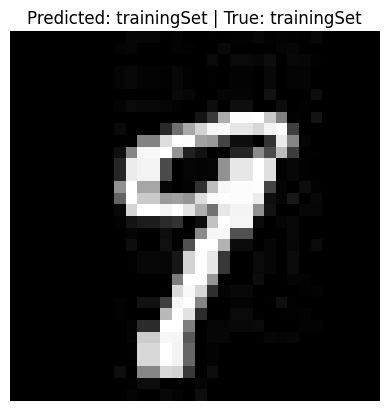

In [43]:
# === STEP 10: Predict and visualize ===
pred = model.predict(x_test)
labels = list(train_gen.class_indices.keys())

plt.imshow(x_test[10])
plt.title(f"Predicted: {labels[np.argmax(pred[10])]} | True: {labels[np.argmax(y_test[10])]}")
plt.axis('off')
plt.show()